In [38]:
import numpy as np
!pip install OpenAI
!pip install langchain_openai
import torch
from openai import OpenAI
import pickle
import os
!pip install faiss-cpu
import faiss
import pandas as pd
import matplotlib.pyplot as plt
!pip install sentence_transformers
import copy
from collections import Counter, defaultdict
import math
from sentence_transformers import CrossEncoder
from langchain.docstore.document import Document
from typing import List
import time
import os
import openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


^C
ERROR: Operation cancelled by user
^C
Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 980, in exec_module
  File "<frozen site>", line 642, in <module>
  File "<frozen site>", line 635, in main
  File "<frozen site>", line 574, in execsitecustomize
  File "/usr/lib/python3.11/sitecustomize.py", line 3, in <module>
    from log import Log
  File "/usr/local/lib/python3.11/dist-packages/log.py", line 5, in <module>
    import google.auth
  File "/usr/local/lib/python3.11/dist-packages/google/auth/__init__.py", line 22, in <module>
    from google.auth._default import (
KeyboardInterrupt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
pref_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {pref_device}")

Using device: cuda


In [40]:
# from sentence_transformers import SentenceTransformer
# sentences = ['What are Large Language Models?','مدل های زبانی بزرگ چه هستند؟']

# model = SentenceTransformer('heydariAI/persian-embeddings')
# embeddings = model.encode(sentences)
# print(embeddings)

In [41]:
# Load the CSV into a Pandas DataFrame
file_path = '/kaggle/input/lifewebnews/your_file.csv'
df = pd.read_csv(file_path)

#fill na in the content column that has the nan values
df['content'] = df['content'].fillna('')

# Plot the hsitogram of lenght of content to have an idea how our data is structured

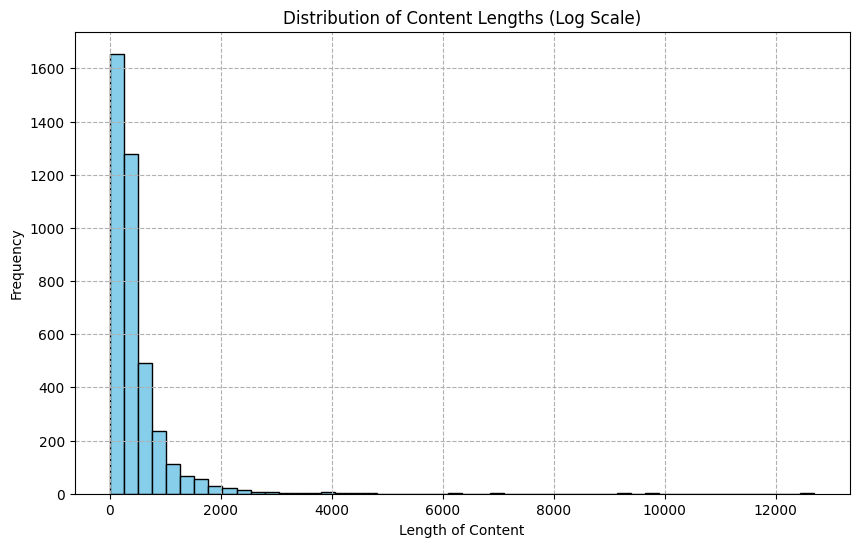

In [42]:
df['content_length'] = df['content'].apply(lambda x: len(str(x).split()))

# Plot histogram of content lengths
plt.figure(figsize=(10, 6))
plt.hist(df['content_length'], bins=50, color='skyblue', edgecolor='black')

# Set the y-axis to logarithmic scale
# plt.yscale('log')

plt.title('Distribution of Content Lengths (Log Scale)')
plt.xlabel('Length of Content')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--")
plt.show()

# The input lenght of text-embedding for persian embedding models are mostly 512 so we cant use the original file. we have to summerize the text so we can use these embeddings for first semantic retirieval stage by Facebook FAISS library. but we do keyword serach by BM25 to not skip any information.


In [57]:
import numpy as np
from langchain_openai import ChatOpenAI
from sentence_transformers import SentenceTransformer

class LLM:
    def __init__(self, chat_model, api_key, embedding_model='heydariAI/persian-embeddings'):#"all-MiniLM-L6-v2"):
        self.api_key = api_key
        self.chat_model = chat_model
        self.embedding_model = embedding_model
        
        self.chat_llm = ChatOpenAI(
            api_key=self.api_key,
            model_name=self.chat_model
        )
        self.embeddings = SentenceTransformer(self.embedding_model,device=pref_device)
        self.embedding_shape = self.get_embedding('this is a simple text').shape[1]

    def get_message(self, text_input, prompt="You are a helpful assistant"):
        messages = [
            ("system", prompt),
            ("human", text_input)
        ]
        return self.chat_llm.invoke(messages).content

    def get_embedding(self, text):
        if isinstance(text, str):
            text = [text]  
        return np.array(self.embeddings.encode(text))
    def get_abstract(self,input_text):
        abstract_prompt="you are an expert who summerizes a persian news text to reflect the all information of the text into 400 to 450 persian words. This text is going to be used for persian semantic serach with respect to user query. here is the text:"""
        def generate_abstract(input_text,prompt, max_retries=3):
            for attempt in range(max_retries):
                try:
                    return llm.get_message(input_text,prompt)
                except (openai.error.RateLimitError, openai.error.APIConnectionError, openai.error.ServiceUnavailableError, openai.error.Timeout) as e:
                    print(f"Transient error on attempt {attempt+1}: {e}")
                    wait_time = 2 ** attempt * 60  # Exponential backoff: 1 min, 2 min, 4 min
                    print(f"Waiting for {wait_time} seconds before retrying...")
                    time.sleep(wait_time)
                except openai.error.OpenAIError as e:
                    print(f"Non-transient error: {e}")
                    raise  # Raise to stop the script for critical errors
            print("Max retries reached. Giving up.")
            return None
        
        try:
            abstract = generate_abstract(input_text,abstract_prompt)
            if abstract is not None:
                return abstract
            else:
                print(f"Failed to generate abstract for prompt {i} after max retries.")
        except Exception as e:
            print(f"Critical error occurred: {e}")
            raise
llm = LLM(chat_model="gpt-4o-mini",api_key = "sk-")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
class Semantic_Searh:
    def __init__(self, embedding_shape):
        self.index = faiss.IndexFlatL2(embedding_shape)
        self.embeded_dictionary = {}

    def lenght(self):
        return len(self.embeded_dictionary)

    def search(self, embed_query, k=2048):
        D, I = self.index.search(embed_query, k)
        return ([self.embeded_dictionary[item] for item in I[0]], D[0])

    def add_item(self, embed, file_id):
        self.index.add(copy.deepcopy(embed))
        self.embeded_dictionary[self.index.ntotal-1] = [file_id]

In [45]:
class Semantic_KG:
    def __init__(self,llm):
        self.relations={}
        self.raw_documents=[]
        self.llm=llm
        self.embed_shape=llm.embedding_shape
        self.embedding_function=llm.get_embedding
        self.news_index=Semantic_Searh(self.embed_shape)
        model_name = 'safora/reranker-xlm-roberta-large'
        self.cross_encoder = CrossEncoder(model_name,device=pref_device)

    def save(self):
        with open('knowledge_graph.pkl', 'wb') as f:
            pickle.dump(self.relations, f)

    def load(self):
        try:
            with open('knowledge_graph.pkl', 'rb') as f:
                self.relations = pickle.load(f)
            for key in self.relations.keys():
                self.raw_documents.append(self.relations[key]['title']+'\n'+self.relations[key]['content'])
            for index in self.relations.keys():
                self.news_index.add_item(
                    self.relations[index]['embeded'], index)
        except Exception as e:
            print(f"Failed to load the data from knowledge_graph.pkl")
            
    def bm25_search(self,documents, query,numb_candidates, k1=1.2, b=0.75):
        def tokenize(text):
            return text.lower().split()
        documents_tokenized = [tokenize(doc) for doc in documents]
        query_tokenized = tokenize(query)
        N = len(documents_tokenized)
        if N == 0:
            return []
        doc_freq = defaultdict(int)
        for doc in documents_tokenized:
            for term in set(doc):
                doc_freq[term] += 1
        idf = {term: math.log((N - freq + 0.5) / (freq + 0.5)) for term, freq in doc_freq.items()}
        doc_lengths = [len(doc) for doc in documents_tokenized]
        avgdl = sum(doc_lengths) / N if doc_lengths else 0
        documents_tf = [Counter(doc) for doc in documents_tokenized]
        all_terms = set(term for doc in documents_tokenized for term in doc)
        query_terms = set(query_tokenized) & all_terms
        scores = []
        for i, tf_D in enumerate(documents_tf):
            D_len = doc_lengths[i]
            score = 0
            for q in query_terms:
                f_qi_D = tf_D.get(q, 0)
                scaling = 1 - b + b * (D_len / avgdl if avgdl > 0 else 0)
                denominator = f_qi_D + k1 * scaling
                if denominator > 0:
                    score += idf[q] * f_qi_D * (k1 + 1) / denominator
            scores.append((i, score))
            
        bm25_results=[i for i, _ in sorted(scores, key=lambda x: x[1], reverse=True)]
        return bm25_results[0:numb_candidates]
        
            
    def add_item(self,relation):
        self.raw_documents.append(relation['title']+'\n'+relation['content'])
        
        index=len(self.relations)
        self.relations[index]={}
        self.relations[index]['content'] = relation['content']
        self.relations[index]['title'] = relation['title']
        self.relations[index]['url'] = relation['url']
        self.relations[index]['abstract'] = self.llm.get_abstract(relation['title']+'\n'+relation['content'])
        
        self.relations[index]['embeded'] = llm.get_embedding(self.relations[index]['abstract'])
        self.news_index.add_item(self.relations[index]['embeded'],index)
        print(f'{index} item added!')
        
    def CE_rerank(self, query, candidates,cross_encoder):
        pairs = [[query, can[1]] for can in candidates]
        ranks = cross_encoder.predict(pairs)
        return sorted(zip(candidates, ranks), key=lambda x: -x[1])   
        
    def serach_index(self, index, query, k, threshold=2000):
        k = min(index.lenght(), k)
        results = index.search(self.embedding_function([query]), k=k)
        k_top_indexes = []
        for item, id in zip(results[0], range(len(results[1]))):
            if threshold > 0:
                if results[1][id] < threshold:
                    k_top_indexes.append((item[0], results[1][id]))
            else:
                k_top_indexes.append((item[0], results[1][id]))
        return k_top_indexes
    
    def serach(self,request,k=50):
        candidates=[]
            
        k_top_r=self.serach_index(self.news_index,request,k)
        for item in k_top_r:
            candidates.append(item[0])
        candidates=candidates+self.bm25_search(self.raw_documents,request,k)
        
        unranked_articles_ids = set(candidates)
        candidates = []
        for item in unranked_articles_ids:
            candidates.append((item, self.relations[item]['abstract']))
        CE_rels_reranked = self.CE_rerank(request, candidates,self.cross_encoder)
        return [(i[0][1],i[1]) for i in CE_rels_reranked[0:20]]

In [47]:
#run this with main api

# SS=Semantic_KG(llm)

# SS.load()
# for i in range(len(SS.relations),len(df)):
#     if len(df.iloc[i]['content'])>200:
#         SS.add_item(df.iloc[i])
#     SS.save()

In [59]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import HumanMessage, SystemMessage
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Tuple


@tool
def retrieve_relevant_texts(query: str, top_k: int = 20) -> str:
    """Retrieve the top 20 most relevant persian news articles for a given query."""
    try:
        semantic_serach_results=SS.serach(query,top_k)
        return "\n".join([f"- {i[0]} (Similarity: {i[1]:.2f})" for i in semantic_serach_results])
    except Exception as e:
        return f"Error retrieving news: {str(e)}"

system_prompt = """
You are an intelligent assistant that answer the questions of a user.
For simple factual questions that you are sure about, answer directly using your knowledge. For queries related to news or events, use the retrieve_relevant_texts tool to fetch relevant information before answering. Always provide a clear and concise response.
If the retrived news do not contain enough information to answer the user question correctly return: 'not enough information to answer your question!'"
"""

tools = [retrieve_relevant_texts]
prompt = PromptTemplate(
    input_variables=["input", "agent_scratchpad"],
    template="{agent_scratchpad}\n\nUser query: {input}"
)
agent = create_openai_tools_agent(llm.chat_llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True,max_iterations=1)

def agentic_answer(query: str) -> str:
    try:
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=query)
        ]
        response = agent_executor.invoke({"input": query, "agent_scratchpad": ""})
        return response["output"]
    except Exception as e:
        return f"Error processing query: {str(e)}"


complex_query = "What are the latest news on climate change?"
print("\nComplex Query Response:")
print(agentic_answer(complex_query))


Complex Query Response:


> Entering new AgentExecutor chain...
Error processing query: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
